# Loan Approval Prediction Competition
The goal for this competition is to predict whether an applicant is approved for a loan.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Data Overview and Feature Exploration

Before we explore what models may be suitible or well performing, lets establish what data we have and what format it is in.

In [32]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [33]:
train_df['person_age']

0        37
1        22
2        29
3        30
4        22
         ..
58640    34
58641    28
58642    23
58643    22
58644    31
Name: person_age, Length: 58645, dtype: int64

In [34]:
def engineer_features(df):
    df = df.copy()
    
    df['age_squared'] = df['person_age'] ** 2
    df['is_young'] = (df['person_age'] < 30).astype(int)
    
    df['income_log'] = np.log1p(df['person_income'])
    df['high_income'] = (df['person_income'] > df['person_income'].median()).astype(int)
    
    le = LabelEncoder()
    df['home_ownership_encoded'] = le.fit_transform(df['person_home_ownership'])
    df.drop('person_home_ownership', axis=1, inplace=True)
    
    df['emp_length_log'] = np.log1p(df['person_emp_length'])
    df['is_experienced'] = (df['person_emp_length'] > 5).astype(int)
    
    df = pd.get_dummies(df, columns=['loan_intent'], prefix='intent')

    
    grade_order = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['loan_grade_ordinal'] = df['loan_grade'].map(grade_order)
    df.drop('loan_grade', axis=1, inplace=True)
    
    df['loan_amnt_log'] = np.log1p(df['loan_amnt'])
    df['loan_amnt_to_income'] = df['loan_amnt'] / df['person_income']
   
    df['int_rate_squared'] = df['loan_int_rate'] ** 2
    
    df['high_percent_income'] = (df['loan_percent_income'] > 0.2).astype(int)
    

    df['default_history_encoded'] = le.fit_transform(df['cb_person_default_on_file'])
    df.drop('cb_person_default_on_file', axis=1, inplace=True)
    
    df['cred_hist_length_log'] = np.log1p(df['cb_person_cred_hist_length'])
    df['<5years_credit_history'] = (df['cb_person_cred_hist_length'] < 5).astype(int)
    
    df['income_emp_length_interaction'] = df['income_log'] * df['emp_length_log']
    df['loan_amnt_int_rate_interaction'] = df['loan_amnt_log'] * df['loan_int_rate']
    
    return df


In [35]:
engineered_train = engineer_features(train_df)
engineered_test = engineer_features(test_df)
engineered_train.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,age_squared,...,loan_grade_ordinal,loan_amnt_log,loan_amnt_to_income,int_rate_squared,high_percent_income,default_history_encoded,cred_hist_length_log,<5years_credit_history,income_emp_length_interaction,loan_amnt_int_rate_interaction
0,0,37,35000,0.0,6000,11.49,0.17,14,0,1369,...,2,8.699681,0.171429,132.0201,0,0,2.708050,0,0.000000,99.959339
1,1,22,56000,6.0,4000,13.35,0.07,2,0,484,...,3,8.294300,0.071429,178.2225,0,0,1.098612,1,21.274879,110.728900
2,2,29,28800,8.0,6000,8.90,0.21,10,0,841,...,1,8.699681,0.208333,79.2100,1,0,2.397895,0,22.561465,77.427164
3,3,30,70000,14.0,12000,11.11,0.17,5,0,900,...,2,9.392745,0.171429,123.4321,0,0,1.791759,0,30.211725,104.353400
4,4,22,60000,2.0,6000,6.92,0.10,3,0,484,...,1,8.699681,0.100000,47.8864,0,0,1.386294,1,12.087060,60.201795


#### Is the data clean? are there any errors or bias?
We can see there are no null values in the dataset now lets move onto the spread of the data to see any bias


In [36]:
null_counts_train = train_df.isnull().sum()
null_counts_test = test_df.isnull().sum()

null_counts_combined = pd.concat([null_counts_train, null_counts_test], axis=1)
null_counts_combined.columns = ['Train', 'Test']

null_counts_combined


,Train,Test
id,0,0.0
person_age,0,0.0
person_income,0,0.0
person_home_ownership,0,0.0
person_emp_length,0,0.0
loan_intent,0,0.0
loan_grade,0,0.0
loan_amnt,0,0.0
loan_int_rate,0,0.0
loan_percent_income,0,0.0


Now looking at the spread of how many loans are given, we can see there are far more loans rejected than accepted meaning:
- An evaluation metric such as accuracy is likely to perform poorly as if you predicted rejected for all loans then you would score an accuracy of 85.7%. 
- This inbalance in the dataset may mean that stratified sampling may be useful if cross validaiton is used.
- AUC ROC is a good starting point for the evaluation metric as it is also the metric chosen by the competition

In [37]:
train_df['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [38]:
# sns.pairplot(data=train_df, hue='loan_status')

First trying with PCA to see if there is a linear relationship

Explained Variance Ratio by each component: [1.71945125e-01 1.59250342e-01 1.27354571e-01 1.04558590e-01
 8.15007451e-02 3.98414022e-02 3.91967665e-02 3.87987313e-02
 3.83747591e-02 3.54491801e-02 3.22183874e-02 2.42710949e-02
 2.12409314e-02 1.63699553e-02 1.32920562e-02 1.17310414e-02
 1.13205929e-02 1.06321938e-02 5.48023142e-03 4.93386606e-03
 3.42870730e-03 2.63437953e-03 2.41035370e-03 1.43145327e-03
 9.29579692e-04 6.52284755e-04 4.00013647e-04 2.52534834e-04
 7.29147807e-05 2.72148526e-05 3.55113592e-33]


(0.0, 1.0)

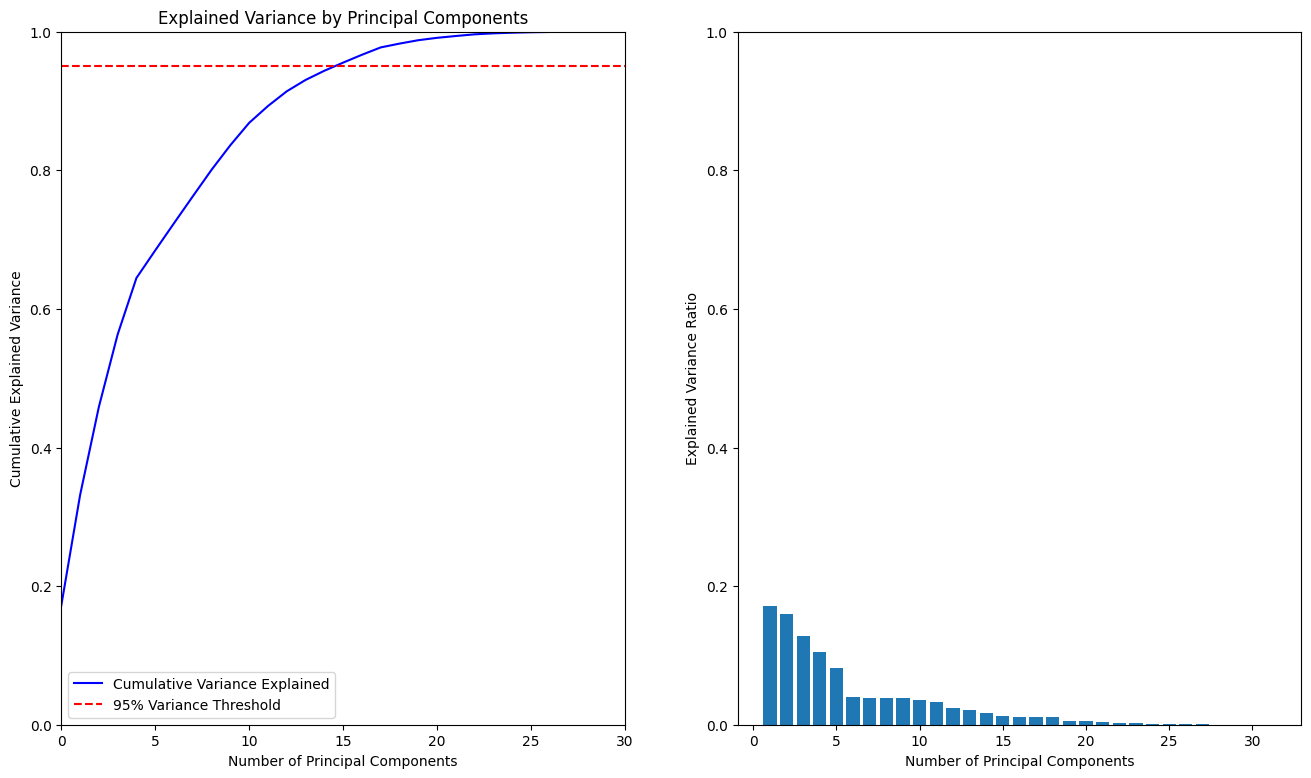

In [39]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(engineered_train.drop('loan_status', axis=1))

pca = PCA(n_components=len(engineered_train.columns) - 1)
pca_result = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio by each component: {explained_variance}")

plt.figure(figsize=(16,9))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(explained_variance), linestyle='-', color='b', label='Cumulative Variance Explained')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance Threshold')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim(0, 1)
plt.xlim(0, len(explained_variance)-1)
plt.title('Explained Variance by Principal Components')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x = range(1, len(explained_variance)+1), height=explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0, 1)  


#### Gradient Boosting (e.g., XGBoost, LightGBM, CatBoost):
- Pros: Great for structured/tabular data, handles non-linear relationships very well, and has built-in feature selection. Generally, boosted trees perform better than 
Random Forests on complex tasks.
- Cons: Requires more tuning and is more computationally intensive.

In [40]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np

X = engineered_train.drop(columns=['loan_status'])
y = engineered_train['loan_status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def objective(space):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': space['eta'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'alpha': space['alpha'],
        'lambda': space['lambda'],
        'seed': 42
    }
    
    model = xgb.XGBClassifier(**params, n_estimators=int(space['n_estimators']))
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='roc_auc')
    
    mean_auc = np.mean(cv_scores)
    return {'loss': -mean_auc, 'status': STATUS_OK}

space = {
    'eta': hp.uniform('eta', 0.005, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0, 1)
}

trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("Best Hyperparameters:", best_hyperparams)


best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': best_hyperparams['eta'],
    'max_depth': int(best_hyperparams['max_depth']),
    'subsample': best_hyperparams['subsample'],
    'colsample_bytree': best_hyperparams['colsample_bytree'],
    'alpha': best_hyperparams['alpha'],
    'lambda': best_hyperparams['lambda'],
    'seed': 42,
    'n_estimators': int(best_hyperparams['n_estimators'])
}

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_scaled, y)

100%|██████████| 100/100 [15:38<00:00,  9.39s/trial, best loss: -0.9555633773569154]
Best Hyperparameters: {'alpha': 0.9988086111083146, 'colsample_bytree': 0.6337218962781319, 'eta': 0.08759690758001829, 'lambda': 0.44915883341432794, 'max_depth': 6.0, 'n_estimators': 200.0, 'subsample': 0.9918252548612417}


XGBClassifier(alpha=0.9988086111083146, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6337218962781319, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.08759690758001829, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.44915883341432794,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)

In [41]:
X_test = engineered_test
X_test_scaled = scaler.transform(X_test)

y_pred_prob = final_model.predict_proba(X_test_scaled)[:, 1]


predictions_df = pd.DataFrame({
    'id': test_df['id'],
    'loan_status': y_pred_prob  # Use probabilities for AUC scoring
})

predictions_df.to_csv('loan_predictions.csv', index=False)

print("Predictions saved to 'loan_predictions.csv'")


Predictions saved to 'loan_predictions.csv'
